# Intro to AI 4 - CW3 Artifical Neural Networks (ANN)

### Setup

In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import itertools


# Set up seeds (reproduceability)
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

if (torch.cuda.is_available()):
    print("CUDA available. Using device: ", torch.cuda.get_device_name())
else:
    print("CUDA is not available. Using device: ", torch.device("cpu"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CUDA is not available. Using device:  cpu


#### Data import

In [2]:
DATA_PATH = r"./interest-rates/index.csv"
df = pd.read_csv(DATA_PATH)

df["date"] = pd.to_datetime(df[["Year", "Month", "Day"]])
df = df.sort_values("date")

print(df.shape)
display(df.head())

(904, 11)


,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate,date
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN,1954-07-01
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN,1954-08-01
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN,1954-09-01
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN,1954-10-01
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN,1954-11-01


In [3]:
def prepare_quarterly_data(df_in: pd.DataFrame, add_lags: bool = False, max_lag: int = 2):
    target_col = "Real GDP (Percent Change)"
    base_feature_cols = [
        "Effective Federal Funds Rate",
        "Unemployment Rate",
        "Inflation Rate",
    ]

    # using a copy of the data
    temp = df_in.copy()
    temp = temp.set_index("date").sort_index()

    # FF between GDP and keep only relevant
    temp[target_col] = temp[target_col].ffill()
    cols_to_keep = [target_col] + base_feature_cols
    temp = temp[cols_to_keep]

    # Interpolate features in time, then back-fill any remaining NAs
    temp[base_feature_cols] = temp[base_feature_cols].interpolate(method="time")
    temp[base_feature_cols] = temp[base_feature_cols].bfill()

    df_q = temp.resample("QS", label="left").mean()

    # create feature lags on this quarterly index.
    feature_cols = base_feature_cols.copy()

    if add_lags:
        for col in base_feature_cols:
            for lag in range(1, max_lag + 1):
                lag_name = f"{col}_lag{lag}q"
                df_q[lag_name] = df_q[col].shift(lag)
                feature_cols.append(lag_name)

        df_q = df_q.dropna(subset=feature_cols + [target_col]) # Drop rows with inital NAs from the lags

    return df_q, feature_cols


In [4]:
# quarterly data with lags
pipeline_input_down_lag, feature_cols_down_lag = prepare_quarterly_data(
    df, add_lags=True, max_lag=2
)

print("Downsampled quarterly + feature lags shape:", pipeline_input_down_lag.shape)

display(pipeline_input_down_lag.head())

Downsampled quarterly + feature lags shape: (249, 10)


,Real GDP (Percent Change),Effective Federal Funds Rate,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate_lag1q,Effective Federal Funds Rate_lag2q,Unemployment Rate_lag1q,Unemployment Rate_lag2q,Inflation Rate_lag1q,Inflation Rate_lag2q
date,,,,,,,,,,
1955-01-01,11.9,1.343333,4.733333,3.2,0.986667,1.026667,5.333333,5.966667,3.2,3.2
1955-04-01,6.7,1.500000,4.400000,3.2,1.343333,0.986667,4.733333,5.333333,3.2,3.2
1955-07-01,5.5,1.940000,4.100000,3.2,1.500000,1.343333,4.400000,4.733333,3.2,3.2
1955-10-01,2.4,2.356667,4.233333,3.2,1.940000,1.500000,4.100000,4.400000,3.2,3.2
1956-01-01,-1.5,2.483333,4.033333,3.2,2.356667,1.940000,4.233333,4.100000,3.2,3.2


In [5]:

data = pipeline_input_down_lag.sort_index()
data = data.reset_index(drop=True)

train_ratio = 0.70
val_ratio   = 0.15

N = len(data)

train_end = int(N * train_ratio)
val_end   = int(N * (train_ratio + val_ratio))

#Split!
train_df = data.iloc[:train_end]
val_df   = data.iloc[train_end:val_end]
test_df  = data.iloc[val_end:]

X_train = train_df[feature_cols_down_lag].values.astype(np.float32)
y_train = train_df["Real GDP (Percent Change)"].values.astype(np.float32)

X_val   = val_df[feature_cols_down_lag].values.astype(np.float32)
y_val   = val_df["Real GDP (Percent Change)"].values.astype(np.float32)

X_test  = test_df[feature_cols_down_lag].values.astype(np.float32)
y_test  = test_df["Real GDP (Percent Change)"].values.astype(np.float32)



#### Standardisation

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)

# aplly transformation to all other feature sets
X_train_scaled = scaler.transform(X_train).astype(np.float32)
X_val_scaled   = scaler.transform(X_val).astype(np.float32)
X_test_scaled  = scaler.transform(X_test).astype(np.float32)

# Pytorch dataset class
class ff_dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)

        # Ensure y is always shape (N, 1)
        if len(y.shape) == 1:              # shape (N,)
            y = y.reshape(-1, 1)           # -> shape (N, 1)

        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = ff_dataset(X_train_scaled, y_train)
val_dataset   = ff_dataset(X_val_scaled, y_val)
test_dataset  = ff_dataset(X_test_scaled, y_test)

### Batches

With another helper function so that I can use it later in hyperparameter tuning

In [7]:
batch_size = 16

def loaders_w_batch_size(batch_size):
    train_dataset = ff_dataset(X_train_scaled, y_train)
    val_dataset   = ff_dataset(X_val_scaled,   y_val)
    test_dataset  = ff_dataset(X_test_scaled, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = loaders_w_batch_size(batch_size)

### Helper functions

I'll use these later for training, evaluating and plotting the model.

In [8]:
def train_one_epoch(model, loader, optimiser, criterion, device):
    model.train()
    running_loss = 0.0
    n_samples = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimiser.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimiser.step()

        batch_size = X_batch.size(0)
        running_loss += loss.item() * batch_size
        n_samples += batch_size

    return running_loss / n_samples

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    n_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            batch_size = X_batch.size(0)
            running_loss += loss.item() * batch_size
            n_samples += batch_size

    return running_loss / n_samples

def plot_loss_curves(train_losses, val_losses, model_name="Model"):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Training Loss (MSE)", linewidth=2)
    plt.plot(epochs, val_losses, label="Validation Loss (MSE)", linewidth=2)

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss (MSE)", fontsize=12)
    plt.title(f"{model_name} Loss Curves", fontsize=14)
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Baseline MLP Model

#### Model definition

In [9]:
input_dim = X_train_scaled.shape[1]   # define training features size
output_dim = 1                        # only output we want is GDP

class BaselineMLP(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 16),
            nn.ReLU(),
            nn.Linear(16, out_features)
        )

    def forward(self, x):
        return self.net(x)

model = BaselineMLP(input_dim, output_dim).to(device)
print(model)


BaselineMLP(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


#### Loss function and optimiser

In [10]:
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=1e-3)

#### Training and evaluation helper functions

These functions can be used with any of the models and will be reused when running through other non-baseline models too.

#### Training loop

[Baseline] Epoch 001 | Train MSE: 29.375374 | Val MSE: 14.847534
[Baseline] Epoch 002 | Train MSE: 28.915018 | Val MSE: 14.362102
[Baseline] Epoch 003 | Train MSE: 28.497244 | Val MSE: 13.895149
[Baseline] Epoch 004 | Train MSE: 28.087551 | Val MSE: 13.434394
[Baseline] Epoch 005 | Train MSE: 27.679085 | Val MSE: 12.971678
[Baseline] Epoch 006 | Train MSE: 27.270397 | Val MSE: 12.501898
[Baseline] Epoch 007 | Train MSE: 26.860033 | Val MSE: 12.027622
[Baseline] Epoch 008 | Train MSE: 26.446624 | Val MSE: 11.543526
[Baseline] Epoch 009 | Train MSE: 26.025396 | Val MSE: 11.045975
[Baseline] Epoch 010 | Train MSE: 25.595053 | Val MSE: 10.530912
[Baseline] Epoch 011 | Train MSE: 25.153578 | Val MSE: 10.001364
[Baseline] Epoch 012 | Train MSE: 24.699593 | Val MSE: 9.455141
[Baseline] Epoch 013 | Train MSE: 24.228235 | Val MSE: 8.888806
[Baseline] Epoch 014 | Train MSE: 23.737117 | Val MSE: 8.322245
[Baseline] Epoch 015 | Train MSE: 23.236169 | Val MSE: 7.766808
[Baseline] Epoch 016 | Train 

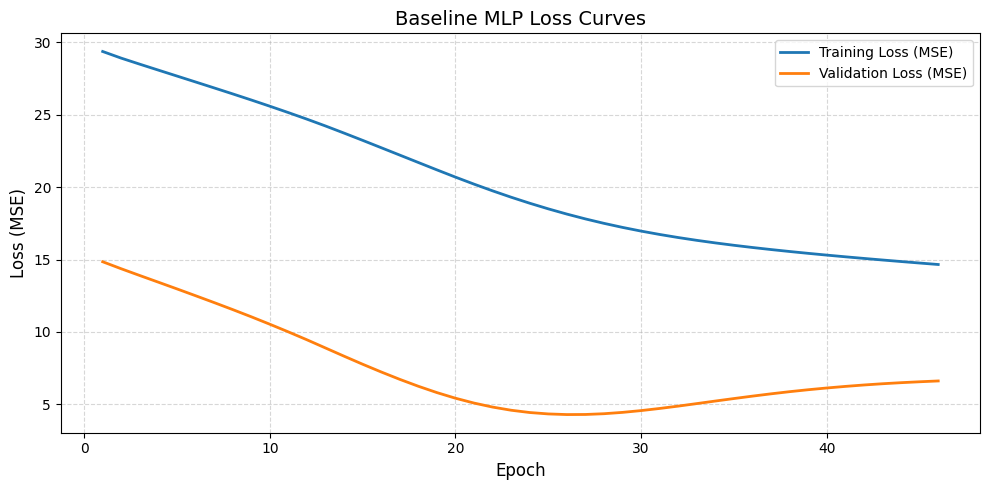

In [11]:
num_epochs = 200 # max number of epochs
patience = 20  # if validation loss doesnt improve after this many epochs, stop.

best_val_loss = float("inf")
best_model_state = None
epochs_no_improve = 0

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimiser, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Baseline] Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")

    if val_loss < best_val_loss - 1e-6:  # check for improvement accounting for potential noise
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # early stopping
    if epochs_no_improve >= patience:
        print(f"[Baseline] Early stopping triggered after {epoch} epochs.")
        break

# load best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("[Baseline] Loaded best model (lowest val MSE).")

test_mse = evaluate(model, test_loader, criterion, device)
print(f"\n[Baseline] Final Test MSE (Baseline MLP): {test_mse:.6f}")

plot_loss_curves(train_losses, val_losses, "Baseline MLP")


The baseline MLP model therefore shows an MSE of around 25, translating to around 4-6 % points. This therefore is not great but works as a good baseline for the model to be developed onto, which is what will be done with the next models. The high MSE value shows that quite a bit of underfitting is taking place in this model. However, before taking this as the baseline's best performance, I will attempt to tune the hyperparameters before moving onto model B

### Baseline MLP tuning

In the code block below I will perform the hyperparameter tuning for the baseline MLP model. This will reuse a lot of the code above (I've decided to keep that above split up for understanding/explanation reasons).


#### Model running function

In [12]:
def run_modelA(learning_rate,batch_size,weight_decay, num_epochs=200, patience=20, extra_info=False, evaluate_model=False):

    # new model for each run
    model = BaselineMLP(input_dim, output_dim).to(device)

    # create loaders
    train_loader, val_loader, test_loader = loaders_w_batch_size(batch_size)

    criterion  = nn.MSELoss()
    optimiser  = optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)

    best_val_loss      = float("inf")
    best_train_loss    = float("inf")
    epochs_no_improve  = 0


    if evaluate_model:
        train_losses = [] # only used if evaluate_model=True
        val_losses = []  # only used if evaluate_model=True

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimiser, criterion, device)
        val_loss   = evaluate(model, val_loader, criterion, device)

        if evaluate_model:
            train_losses.append(train_loss)
            val_losses.append(val_loss)

        if extra_info:
            print(
                f"[Baseline tuning] (lr={learning_rate}, bs={batch_size}, wd={weight_decay}) "
                f"Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}"
            )

        if val_loss < best_val_loss - 1e-6: # check for improvement accounting for potential noise
            best_val_loss     = val_loss
            best_train_loss   = train_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    if evaluate_model:
        test_mse = evaluate(model, test_loader, criterion, device)

        return val_losses, train_losses, test_mse

    return best_val_loss, best_train_loss

#### Hypereparameter grid search

In [13]:
learning_rate_grid = [1e-2, 3e-3, 1e-3]
batch_size_grid    = [8, 16]
weight_decay_grid  = [0.0, 1e-4, 1e-3]

hyperparameter_grid = list(itertools.product(
    learning_rate_grid,
    batch_size_grid,
    weight_decay_grid,
))

print(f"[Baseline tuning] Total combinations to test for Model A: {len(hyperparameter_grid)}")

results = []

for learning_rate, batch_size, weight_decay in hyperparameter_grid:
    best_val_mse, best_train_mse = run_modelA(
        learning_rate=learning_rate,
        batch_size=batch_size,
        weight_decay=weight_decay,
        num_epochs=200,
        patience=20,
        extra_info=False
    )

    results.append({
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "best_val_mse": best_val_mse,
        "train_mse_at_best_val": best_train_mse,
    })

    print(
        f"[Baseline tuning] Done: lr={learning_rate}, bs={batch_size}, wd={weight_decay} "
        f"-> best val MSE = {best_val_mse:.4f}"
    )

results_df_A = pd.DataFrame(results)
display(results_df_A.sort_values("best_val_mse").head(10))

[Baseline tuning] Total combinations to test for Model A: 18
[Baseline tuning] Done: lr=0.01, bs=8, wd=0.0 -> best val MSE = 4.0454
[Baseline tuning] Done: lr=0.01, bs=8, wd=0.0001 -> best val MSE = 3.5159
[Baseline tuning] Done: lr=0.01, bs=8, wd=0.001 -> best val MSE = 3.7581
[Baseline tuning] Done: lr=0.01, bs=16, wd=0.0 -> best val MSE = 3.8442
[Baseline tuning] Done: lr=0.01, bs=16, wd=0.0001 -> best val MSE = 5.0638
[Baseline tuning] Done: lr=0.01, bs=16, wd=0.001 -> best val MSE = 4.3984
[Baseline tuning] Done: lr=0.003, bs=8, wd=0.0 -> best val MSE = 4.3459
[Baseline tuning] Done: lr=0.003, bs=8, wd=0.0001 -> best val MSE = 5.0278
[Baseline tuning] Done: lr=0.003, bs=8, wd=0.001 -> best val MSE = 4.4661
[Baseline tuning] Done: lr=0.003, bs=16, wd=0.0 -> best val MSE = 4.3018
[Baseline tuning] Done: lr=0.003, bs=16, wd=0.0001 -> best val MSE = 4.5633
[Baseline tuning] Done: lr=0.003, bs=16, wd=0.001 -> best val MSE = 4.6893
[Baseline tuning] Done: lr=0.001, bs=8, wd=0.0 -> best 

,learning_rate,batch_size,weight_decay,best_val_mse,train_mse_at_best_val
1,0.010,8,0.0001,3.515854,6.038148
2,0.010,8,0.0010,3.758110,7.627946
3,0.010,16,0.0000,3.844234,6.970785
0,0.010,8,0.0000,4.045379,11.583219
16,0.001,16,0.0001,4.182307,18.066201
17,0.001,16,0.0010,4.220558,18.113710
9,0.003,16,0.0000,4.301795,18.387516
6,0.003,8,0.0000,4.345915,18.720135
15,0.001,16,0.0000,4.366970,16.050657
5,0.010,16,0.0010,4.398385,19.374570


#### Analyse tuning results and evaluate best model
The following code will use the top row of the output table (sorted by best val MSE) and use that to retrain and evaluate that specific model.

[Baseline tuning] (lr=0.01, bs=8, wd=0.0001) Epoch 001 | Train MSE: 23.415623 | Val MSE: 5.981829
[Baseline tuning] (lr=0.01, bs=8, wd=0.0001) Epoch 002 | Train MSE: 17.767317 | Val MSE: 6.513158
[Baseline tuning] (lr=0.01, bs=8, wd=0.0001) Epoch 003 | Train MSE: 14.564511 | Val MSE: 9.224914
[Baseline tuning] (lr=0.01, bs=8, wd=0.0001) Epoch 004 | Train MSE: 13.481127 | Val MSE: 7.094464
[Baseline tuning] (lr=0.01, bs=8, wd=0.0001) Epoch 005 | Train MSE: 12.174804 | Val MSE: 6.886540
[Baseline tuning] (lr=0.01, bs=8, wd=0.0001) Epoch 006 | Train MSE: 11.397006 | Val MSE: 7.130812
[Baseline tuning] (lr=0.01, bs=8, wd=0.0001) Epoch 007 | Train MSE: 10.895755 | Val MSE: 5.168839
[Baseline tuning] (lr=0.01, bs=8, wd=0.0001) Epoch 008 | Train MSE: 11.105067 | Val MSE: 10.439690
[Baseline tuning] (lr=0.01, bs=8, wd=0.0001) Epoch 009 | Train MSE: 12.283943 | Val MSE: 4.173022
[Baseline tuning] (lr=0.01, bs=8, wd=0.0001) Epoch 010 | Train MSE: 12.446292 | Val MSE: 11.187589
[Baseline tuning] 

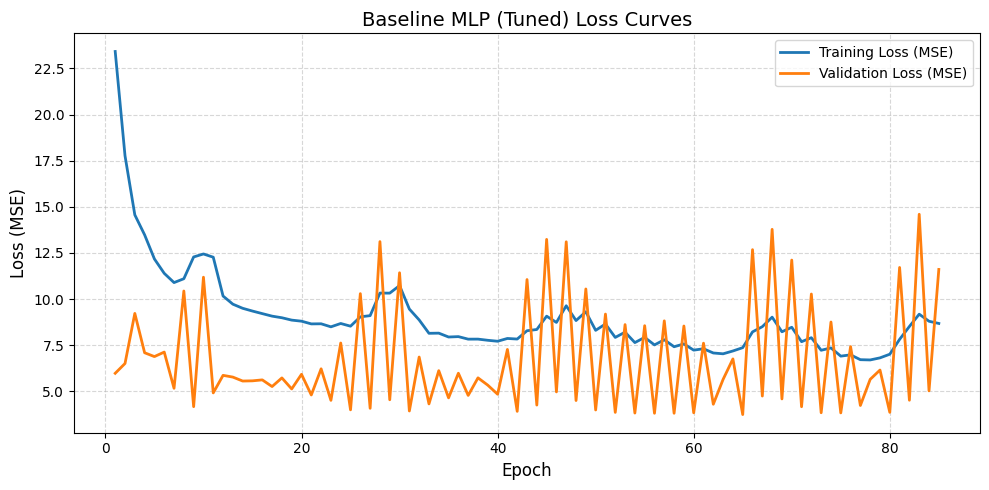

In [14]:
best_row_A = results_df_A.sort_values("best_val_mse").iloc[0]

best_lr        = float(best_row_A["learning_rate"])
best_bs        = int(best_row_A["batch_size"])
# best_bs        = int(best_row_A["batch_size"])*2
best_wd        = float(best_row_A["weight_decay"])

model_A_val_losses, model_A_train_losses, model_A_tuned_test_mse = run_modelA(best_lr, best_bs, best_wd, evaluate_model=True, extra_info=True)
print(f"\n[Baseline tuning] Final Tuned Test MSE (Baseline MLP): {model_A_tuned_test_mse:.6f}")

# print(model_A_val_losses)
# print(model_A_train_losses)

plot_loss_curves(model_A_train_losses, model_A_val_losses, "Baseline MLP (Tuned)")


This hyperparameter tuned model (using LR=0.01, BS=8, WD=0.0001) has the best performance, and results in a test MSE of 18, improved from 25 without tuning.

### Wider + Deeper (Model B)

#### Class definition

In [15]:
class Wider_Deeper_MLP(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 32),  # hidden layer (wider)
            nn.ReLU(),
            nn.Linear(32, 16),           # hidden layer (deeper)
            nn.ReLU(),
            nn.Linear(16, out_features)  # output layer
        )

        # He (Kaiming) initialisation for ReLU layers
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

model_B = Wider_Deeper_MLP(input_dim, output_dim).to(device)
print(model_B)

Wider_Deeper_MLP(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)


#### Loss function and optimiser

In [16]:
criterion_B = nn.MSELoss()
optimiser_B = optim.Adam(model_B.parameters(), lr=1e-3)

#### Training loop

[Model B] Epoch 001 | Train MSE: 34.462686 | Val MSE: 22.572076
[Model B] Epoch 002 | Train MSE: 31.212742 | Val MSE: 18.916119
[Model B] Epoch 003 | Train MSE: 28.589496 | Val MSE: 15.787200
[Model B] Epoch 004 | Train MSE: 26.180405 | Val MSE: 12.908998
[Model B] Epoch 005 | Train MSE: 23.872493 | Val MSE: 10.348922
[Model B] Epoch 006 | Train MSE: 21.728309 | Val MSE: 8.300105
[Model B] Epoch 007 | Train MSE: 19.850849 | Val MSE: 6.706016
[Model B] Epoch 008 | Train MSE: 18.189108 | Val MSE: 5.542482
[Model B] Epoch 009 | Train MSE: 16.743838 | Val MSE: 4.806470
[Model B] Epoch 010 | Train MSE: 15.506433 | Val MSE: 4.448742
[Model B] Epoch 011 | Train MSE: 14.467389 | Val MSE: 4.435342
[Model B] Epoch 012 | Train MSE: 13.636812 | Val MSE: 4.740284
[Model B] Epoch 013 | Train MSE: 13.015063 | Val MSE: 5.254278
[Model B] Epoch 014 | Train MSE: 12.544942 | Val MSE: 5.864765
[Model B] Epoch 015 | Train MSE: 12.201656 | Val MSE: 6.473807
[Model B] Epoch 016 | Train MSE: 11.944350 | Val M

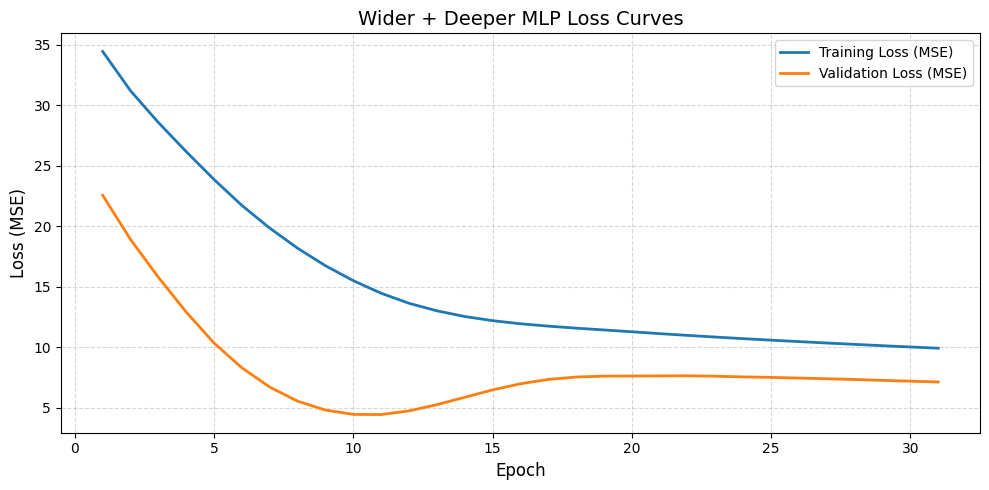

In [17]:
num_epochs_B = 200 # max number of epochs
patience_B = 20  # if validation loss doesnt improve after this many epochs, stop.

best_val_loss_B = float("inf")
best_model_state_B = None
epochs_no_improve_B = 0

train_losses_B = []
val_losses_B = []

for epoch in range(1, num_epochs_B + 1):
    train_loss = train_one_epoch(model_B, train_loader, optimiser_B, criterion_B, device)
    val_loss = evaluate(model_B, val_loader, criterion_B, device)

    train_losses_B.append(train_loss)
    val_losses_B.append(val_loss)

    print(f"[Model B] Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")

    if val_loss < best_val_loss_B - 1e-6:  # check for improvement accounting for potential noise
        best_val_loss_B = val_loss
        best_model_state_B = model_B.state_dict()
        epochs_no_improve_B = 0
    else:
        epochs_no_improve_B += 1

    if epochs_no_improve_B >= patience_B:
        print(f"[Model B] Early stopping triggered after {epoch} epochs.")
        break

# Load best model weights for Model B
if best_model_state_B is not None:
    model_B.load_state_dict(best_model_state_B)
    print("[Model B] Loaded best model (lowest val MSE).")

test_mse_B = evaluate(model_B, test_loader, criterion_B, device)
print(f"\n[Model B] Final Test MSE: {test_mse_B:.6f}")
plot_loss_curves(train_losses_B, val_losses_B, "Wider + Deeper MLP")


### Wider + Deeper MLP (Model B) Tuning

(Similar hyperparameters as Model A, uses modified code from model A tuning)

#### Model running function

In [18]:
def run_modelB(learning_rate,batch_size,weight_decay, num_epochs=200, patience=20, extra_info=False, evaluate_model=False):

    # new model for each run
    model = Wider_Deeper_MLP(input_dim, output_dim).to(device)

    # create loaders
    train_loader, val_loader, test_loader = loaders_w_batch_size(batch_size)

    criterion  = nn.MSELoss()
    optimiser  = optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)

    best_val_loss = float("inf")
    best_train_loss = float("inf")
    best_model_state = None
    epochs_no_improve  = 0

    if evaluate_model:
        train_losses = [] # only used if evaluate_model=True
        val_losses = []  # only used if evaluate_model=True

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimiser, criterion, device)
        val_loss   = evaluate(model, val_loader, criterion, device)

        if evaluate_model:
            train_losses.append(train_loss)
            val_losses.append(val_loss)

        if extra_info:
            print(
                f"[Model B tuning] (lr={learning_rate}, bs={batch_size}, wd={weight_decay}) "
                f"Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}"
            )

        if val_loss < best_val_loss - 1e-6: # check for improvement accounting for potential noise
            best_val_loss     = val_loss
            best_train_loss   = train_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    # Load best model weights for Model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("[Model B] Loaded best model (lowest val MSE).")

    if evaluate_model:
        test_mse = evaluate(model, test_loader, criterion, device)

        return val_losses, train_losses, test_mse

    return best_val_loss, best_train_loss

#### Hyperparameter Grid Search

In [19]:
learning_rate_grid_B = [1e-2, 3e-3, 1e-3]
batch_size_grid_B    = [8, 16]
weight_decay_grid_B  = [0.0, 1e-4, 1e-3]

hyperparameter_grid_B = list(itertools.product(
    learning_rate_grid_B,
    batch_size_grid_B,
    weight_decay_grid_B,
))

print(f"Total combinations to test for Model B: {len(hyperparameter_grid_B)}")

results_B = []

for learning_rate, batch_size, weight_decay in hyperparameter_grid_B:
    best_val_mse, best_train_mse = run_modelB(
        learning_rate=learning_rate,
        batch_size=batch_size,
        weight_decay=weight_decay,
        num_epochs=200,
        patience=20
    )

    results_B.append({
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "best_val_mse": best_val_mse,
        "train_mse_at_best_val": best_train_mse,
    })

    print(
        f"[Model B tuning] Done: lr={learning_rate}, bs={batch_size}, wd={weight_decay} "
        f"-> best val MSE = {best_val_mse:.4f}"
    )

results_df_B = pd.DataFrame(results_B)
display(results_df_B.sort_values("best_val_mse").head(10))

Total combinations to test for Model B: 18
[Model B] Loaded best model (lowest val MSE).
[Model B tuning] Done: lr=0.01, bs=8, wd=0.0 -> best val MSE = 5.0150
[Model B] Loaded best model (lowest val MSE).
[Model B tuning] Done: lr=0.01, bs=8, wd=0.0001 -> best val MSE = 3.8058
[Model B] Loaded best model (lowest val MSE).
[Model B tuning] Done: lr=0.01, bs=8, wd=0.001 -> best val MSE = 4.2805
[Model B] Loaded best model (lowest val MSE).
[Model B tuning] Done: lr=0.01, bs=16, wd=0.0 -> best val MSE = 3.9292
[Model B] Loaded best model (lowest val MSE).
[Model B tuning] Done: lr=0.01, bs=16, wd=0.0001 -> best val MSE = 4.2318
[Model B] Loaded best model (lowest val MSE).
[Model B tuning] Done: lr=0.01, bs=16, wd=0.001 -> best val MSE = 3.7715
[Model B] Loaded best model (lowest val MSE).
[Model B tuning] Done: lr=0.003, bs=8, wd=0.0 -> best val MSE = 5.2118
[Model B] Loaded best model (lowest val MSE).
[Model B tuning] Done: lr=0.003, bs=8, wd=0.0001 -> best val MSE = 4.7969
[Model B] L

,learning_rate,batch_size,weight_decay,best_val_mse,train_mse_at_best_val
5,0.010,16,0.0010,3.771478,6.359388
1,0.010,8,0.0001,3.805793,6.878171
3,0.010,16,0.0000,3.929184,7.985390
17,0.001,16,0.0010,4.079665,17.624051
15,0.001,16,0.0000,4.122677,15.109641
16,0.001,16,0.0001,4.186178,16.376558
4,0.010,16,0.0001,4.231839,10.279245
2,0.010,8,0.0010,4.280475,9.321036
13,0.001,8,0.0001,4.572976,18.547784
14,0.001,8,0.0010,4.626930,16.735430


#### Best tune plotter

[Model B tuning] (lr=0.01, bs=16, wd=0.001) Epoch 001 | Train MSE: 23.271127 | Val MSE: 4.425446
[Model B tuning] (lr=0.01, bs=16, wd=0.001) Epoch 002 | Train MSE: 14.477175 | Val MSE: 16.352509
[Model B tuning] (lr=0.01, bs=16, wd=0.001) Epoch 003 | Train MSE: 14.163683 | Val MSE: 6.306121
[Model B tuning] (lr=0.01, bs=16, wd=0.001) Epoch 004 | Train MSE: 12.034351 | Val MSE: 5.196809
[Model B tuning] (lr=0.01, bs=16, wd=0.001) Epoch 005 | Train MSE: 11.265269 | Val MSE: 6.548939
[Model B tuning] (lr=0.01, bs=16, wd=0.001) Epoch 006 | Train MSE: 10.648035 | Val MSE: 6.337728
[Model B tuning] (lr=0.01, bs=16, wd=0.001) Epoch 007 | Train MSE: 10.065916 | Val MSE: 5.869694
[Model B tuning] (lr=0.01, bs=16, wd=0.001) Epoch 008 | Train MSE: 9.663755 | Val MSE: 5.932960
[Model B tuning] (lr=0.01, bs=16, wd=0.001) Epoch 009 | Train MSE: 9.592010 | Val MSE: 5.909698
[Model B tuning] (lr=0.01, bs=16, wd=0.001) Epoch 010 | Train MSE: 15.317482 | Val MSE: 4.942027
[Model B tuning] (lr=0.01, bs=1

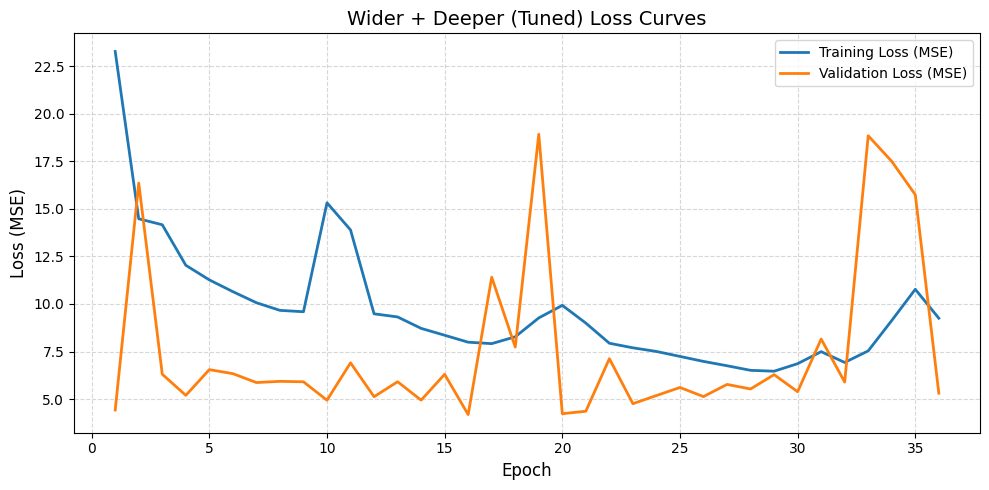

In [20]:
best_row_B = results_df_B.sort_values("best_val_mse").iloc[0]

best_lr_B = float(best_row_B["learning_rate"])
best_bs_B = int(best_row_B["batch_size"])
best_wd_B = float(best_row_B["weight_decay"])

model_B_val_losses, model_B_train_losses, model_B_tuned_test_mse = run_modelB(best_lr_B, best_bs_B, best_wd_B, evaluate_model=True, extra_info=True)
print(f"\n[Model B tuning] Final Tuned Test MSE (Wider + Deeper MLP): {model_B_tuned_test_mse:.6f}")

plot_loss_curves(model_B_train_losses, model_B_val_losses, "Wider + Deeper (Tuned)")


### Regularisation MLP (Model C)

#### Class definition

In [21]:
class regularisation_MLP(nn.Module):
    def __init__(self, in_features, out_features, dropout_p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(16, out_features),
        )

        # He (Kaiming) initialisation for ReLU layers
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

model_C = regularisation_MLP(input_dim, output_dim).to(device)
print(model_C)


regularisation_MLP(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


#### Loss function and Optimisation

In [22]:
criterion_C = nn.MSELoss()
optimiser_C = optim.Adam(model_C.parameters(), lr=1e-3)

#### Training Loop

[Model C] Epoch 001 | Train MSE: 8.710763 | Val MSE: 5.669735
[Model C] Epoch 002 | Train MSE: 8.907611 | Val MSE: 5.888774
[Model C] Epoch 003 | Train MSE: 9.165759 | Val MSE: 5.815786
[Model C] Epoch 004 | Train MSE: 8.327583 | Val MSE: 5.402067
[Model C] Epoch 005 | Train MSE: 7.878446 | Val MSE: 5.362937
[Model C] Epoch 006 | Train MSE: 7.705978 | Val MSE: 5.500036
[Model C] Epoch 007 | Train MSE: 7.868457 | Val MSE: 5.700920
[Model C] Epoch 008 | Train MSE: 8.287352 | Val MSE: 5.533668
[Model C] Epoch 009 | Train MSE: 9.077058 | Val MSE: 5.498145
[Model C] Epoch 010 | Train MSE: 7.736629 | Val MSE: 5.544245
[Model C] Epoch 011 | Train MSE: 8.068870 | Val MSE: 5.728130
[Model C] Epoch 012 | Train MSE: 8.690205 | Val MSE: 5.702304
[Model C] Epoch 013 | Train MSE: 8.772829 | Val MSE: 5.830593
[Model C] Epoch 014 | Train MSE: 8.814296 | Val MSE: 5.766369
[Model C] Epoch 015 | Train MSE: 8.594931 | Val MSE: 5.708687
[Model C] Epoch 016 | Train MSE: 8.151827 | Val MSE: 5.584363
[Model C

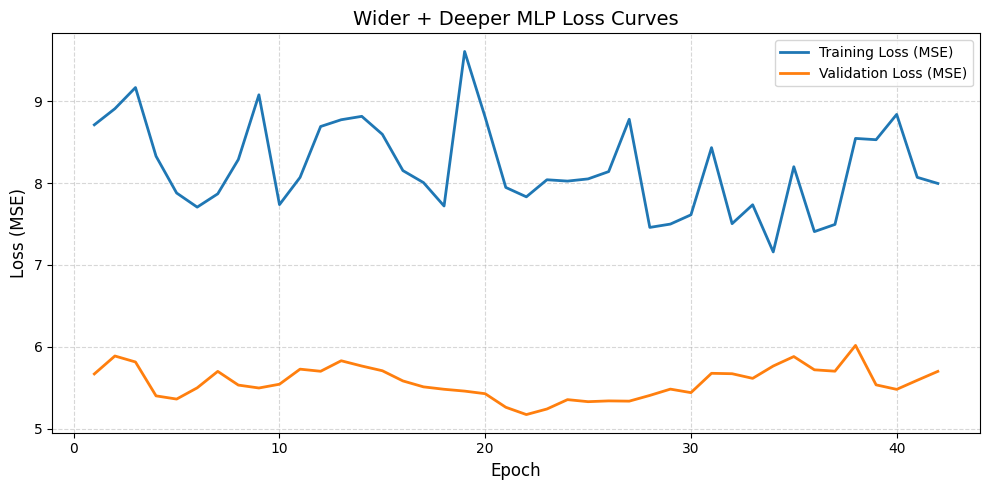

In [29]:
num_epochs_C = 200 # max number of epochs
patience_C = 20  # if validation loss doesnt improve after this many epochs, stop.

best_val_loss_C = float("inf")
best_model_state_C = None
epochs_no_improve_C = 0

train_losses_C = []
val_losses_C = []

for epoch in range(1, num_epochs_C + 1):
    train_loss = train_one_epoch(model_C, train_loader, optimiser_C, criterion_C, device)
    val_loss = evaluate(model_C, val_loader, criterion_C, device)

    train_losses_C.append(train_loss)
    val_losses_C.append(val_loss)

    print(f"[Model C] Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")

    if val_loss < best_val_loss_C - 1e-6:  # check for improvement accounting for potential noise
        best_val_loss_C = val_loss
        best_model_state_C = model_C.state_dict()
        epochs_no_improve_C = 0
    else:
        epochs_no_improve_C += 1

    if epochs_no_improve_C >= patience_C:
        print(f"[Model C] Early stopping triggered after {epoch} epochs.")
        break

# Load best model weights for Model C
if best_model_state_C is not None:
    model_C.load_state_dict(best_model_state_C)
    print("[Model C] Loaded best model (lowest val MSE).")

test_mse_C = evaluate(model_C, test_loader, criterion_C, device)
print(f"\n[Model C] Final Test MSE: {test_mse_C:.6f}")
plot_loss_curves(train_losses_C, val_losses_C, "Wider + Deeper MLP")


### Regularisation MLP Tuning

#### Model running function

In [30]:
def run_modelC(learning_rate, batch_size, weight_decay, dropout_p,
                          num_epochs=200, patience=20, extra_info=False, evaluate_model=False):
    """
    Train Model C (ModelC_MLP) with a specific set of hyperparameters and
    return the best validation MSE and corresponding training MSE.
    """

    # Fresh Model C for this run (same architecture as Model B, but with dropout)
    model_C = regularisation_MLP(input_dim, output_dim, dropout_p=dropout_p).to(device)

    # Fresh loaders in case batch size changes
    train_loader, val_loader, test_loader = loaders_w_batch_size(batch_size)

    criterion  = nn.MSELoss()
    optimiser  = optim.Adam(
        model_C.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
    )

    best_val_loss      = float("inf")
    best_train_loss    = float("inf")
    best_model_state   = None
    epochs_no_improve  = 0

    if evaluate_model:
        train_losses = [] # only used if evaluate_model=True
        val_losses = []  # only used if evaluate_model=True

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model_C, train_loader, optimiser, criterion, device)
        val_loss   = evaluate(model_C, val_loader, criterion, device)

        if evaluate_model:
            train_losses.append(train_loss)
            val_losses.append(val_loss)

        if extra_info:
            print(
                f"[Model C tuning] (lr={learning_rate}, bs={batch_size}, wd={weight_decay}, p={dropout_p} "
                f"Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}"
            )

        # Early stopping based on validation loss
        if val_loss < best_val_loss - 1e-6:  # small delta to avoid floating-point noise
            best_val_loss     = val_loss
            best_train_loss   = train_loss
            best_model_state  = model_C.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    # Optionally reload best weights if you want to reuse the model afterwards
    if best_model_state is not None:
        model_C.load_state_dict(best_model_state)

    if evaluate_model:
        test_mse = evaluate(model, test_loader, criterion, device)

        return val_losses, train_losses, test_mse

    return best_val_loss, best_train_loss

#### Hyperparameter Grid

In [36]:
learning_rate_grid_C = [1e-3, 3e-4]
batch_size_grid_C    = [8, 16]
weight_decay_grid_C  = [0.0, 1e-4]
dropout_grid_C       = [0.1, 0.2, 0.3]

hyperparameter_grid_C = list(itertools.product(
    learning_rate_grid_C,
    batch_size_grid_C,
    weight_decay_grid_C,
    dropout_grid_C,
))

print(f"Total combinations to test for Model C: {len(hyperparameter_grid_C)}")

results_C = []

for learning_rate, batch_size, weight_decay, dropout_p in hyperparameter_grid_C:
    best_val_mse, best_train_mse = run_modelC(
        learning_rate=learning_rate,
        batch_size=batch_size,
        weight_decay=weight_decay,
        dropout_p=dropout_p,
        num_epochs=200,
        patience=20
    )

    results_C.append({
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "dropout_p": dropout_p,
        "best_val_mse": best_val_mse,
        "train_mse_at_best_val": best_train_mse,
    })

    print(
        f"[Model C tuning] Done: lr={learning_rate}, bs={batch_size}, wd={weight_decay}, p={dropout_p} "
        f"-> best val MSE = {best_val_mse:.4f}"
    )

results_df_C = pd.DataFrame(results_C)
display(results_df_C.sort_values("best_val_mse").head(10))

Total combinations to test for Model C: 24
[Model C tuning] Done: lr=0.001, bs=8, wd=0.0, p=0.1 -> best val MSE = 4.1262
[Model C tuning] Done: lr=0.001, bs=8, wd=0.0, p=0.2 -> best val MSE = 4.3332
[Model C tuning] Done: lr=0.001, bs=8, wd=0.0, p=0.3 -> best val MSE = 4.8449
[Model C tuning] Done: lr=0.001, bs=8, wd=0.0001, p=0.1 -> best val MSE = 4.4154
[Model C tuning] Done: lr=0.001, bs=8, wd=0.0001, p=0.2 -> best val MSE = 4.6872
[Model C tuning] Done: lr=0.001, bs=8, wd=0.0001, p=0.3 -> best val MSE = 4.5924
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0, p=0.1 -> best val MSE = 5.2866
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0, p=0.2 -> best val MSE = 5.6278
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0, p=0.3 -> best val MSE = 4.6871
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0001, p=0.1 -> best val MSE = 4.2991
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0001, p=0.2 -> best val MSE = 4.6986
[Model C tuning] Done: lr=0.001, bs=16, wd=0.0001, p=0.3 -> best val MSE = 4.03

,learning_rate,batch_size,weight_decay,dropout_p,best_val_mse,train_mse_at_best_val
17,0.0003,8,0.0001,0.3,3.870032,18.224293
11,0.0010,16,0.0001,0.3,4.036144,17.172375
16,0.0003,8,0.0001,0.2,4.075133,17.981143
12,0.0003,8,0.0000,0.1,4.110594,13.739410
0,0.0010,8,0.0000,0.1,4.126161,21.757162
21,0.0003,16,0.0001,0.1,4.203128,17.887511
22,0.0003,16,0.0001,0.2,4.218374,18.442722
18,0.0003,16,0.0000,0.1,4.284580,15.586264
9,0.0010,16,0.0001,0.1,4.299108,17.805738
15,0.0003,8,0.0001,0.1,4.304693,15.765470


#### Best tune plotter

[Model C tuning] (lr=0.0003, bs=8, wd=0.0001, p=0.3 Epoch 001 | Train MSE: 34.634242 | Val MSE: 19.114046
[Model C tuning] (lr=0.0003, bs=8, wd=0.0001, p=0.3 Epoch 002 | Train MSE: 33.027562 | Val MSE: 17.969747
[Model C tuning] (lr=0.0003, bs=8, wd=0.0001, p=0.3 Epoch 003 | Train MSE: 31.787476 | Val MSE: 16.797432
[Model C tuning] (lr=0.0003, bs=8, wd=0.0001, p=0.3 Epoch 004 | Train MSE: 31.436112 | Val MSE: 15.651222
[Model C tuning] (lr=0.0003, bs=8, wd=0.0001, p=0.3 Epoch 005 | Train MSE: 25.629842 | Val MSE: 14.605426
[Model C tuning] (lr=0.0003, bs=8, wd=0.0001, p=0.3 Epoch 006 | Train MSE: 26.540582 | Val MSE: 13.662525
[Model C tuning] (lr=0.0003, bs=8, wd=0.0001, p=0.3 Epoch 007 | Train MSE: 26.534541 | Val MSE: 12.737380
[Model C tuning] (lr=0.0003, bs=8, wd=0.0001, p=0.3 Epoch 008 | Train MSE: 25.937322 | Val MSE: 11.940976
[Model C tuning] (lr=0.0003, bs=8, wd=0.0001, p=0.3 Epoch 009 | Train MSE: 25.914392 | Val MSE: 11.173712
[Model C tuning] (lr=0.0003, bs=8, wd=0.0001, 

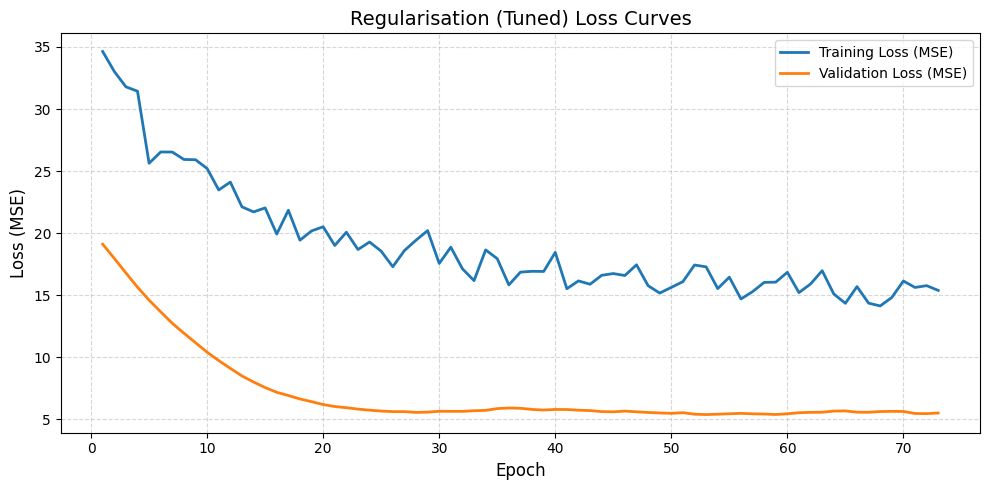

In [37]:
best_row_C = results_df_C.sort_values("best_val_mse").iloc[0]

best_lr_C = float(best_row_C["learning_rate"])
best_bs_C = int(best_row_C["batch_size"])
best_wd_C = float(best_row_C["weight_decay"])
best_do_C = float(best_row_C["dropout_p"])

model_C_val_losses, model_C_train_losses, model_C_tuned_test_mse = run_modelC(best_lr_C, best_bs_C, best_wd_C, best_do_C, evaluate_model=True, extra_info=True)
print(f"\n[Regularisation tuning] Final Tuned Test MSE (Regularisation MLP): {model_C_tuned_test_mse:.6f}")

plot_loss_curves(model_C_train_losses, model_C_val_losses, "Regularisation (Tuned)")
